In [1]:
# Core data processing
import numpy as np
import pandas as pd
import re

# Database
from sqlalchemy import create_engine

# Machine Learning - Core


# Machine Learning - Scikit-learn components
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

 # считываем таблицу user
df_u = pd.read_sql('SELECT * FROM user_data', con=engine) 
print(df_u.shape)
print(df_u.head(2))

 # считываем таблицу post с 7023 постами
df_pt = pd.read_sql('SELECT * FROM post_text_df', con=engine) 
print(df_pt.shape)
print(df_pt.head(2))

# считываем таблицу активностей юзноа (услвие: мин 1 активность на юзера)
uniq_act = pd.read_sql("SELECT DISTINCT ON (user_id, target, action) user_id, post_id, action, timestamp, target FROM public.feed_data WHERE action='view' AND timestamp < '2021-12-29';", con=engine)
acts = pd.read_sql("SELECT * FROM public.feed_data WHERE action='view' AND timestamp < '2021-12-29'  ORDER BY random() LIMIT 2000000;", con=engine)

df_acts = pd.concat([uniq_act, acts], axis=0)
df_acts = df_acts.drop_duplicates()
df = pd.merge(df_u, df_acts, on='user_id',how='left')

(163205, 8)
   user_id  gender  age country       city  exp_group       os source
0      200       1   34  Russia  Degtyarsk          3  Android    ads
1      201       0   37  Russia     Abakan          0  Android    ads
(7023, 3)
   post_id                                               text     topic
0        1  UK economy facing major risks\n\nThe UK manufa...  business
1        2  Aids and climate top Davos agenda\n\nClimate c...  business


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2316912 entries, 0 to 2316911
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user_id    int64         
 1   gender     int64         
 2   age        int64         
 3   country    object        
 4   city       object        
 5   exp_group  int64         
 6   os         object        
 7   source     object        
 8   post_id    int64         
 9   action     object        
 10  timestamp  datetime64[ns]
 11  target     int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 212.1+ MB


In [4]:
df_users = df.drop_duplicates(subset='user_id', keep='first')

# Анализ данных


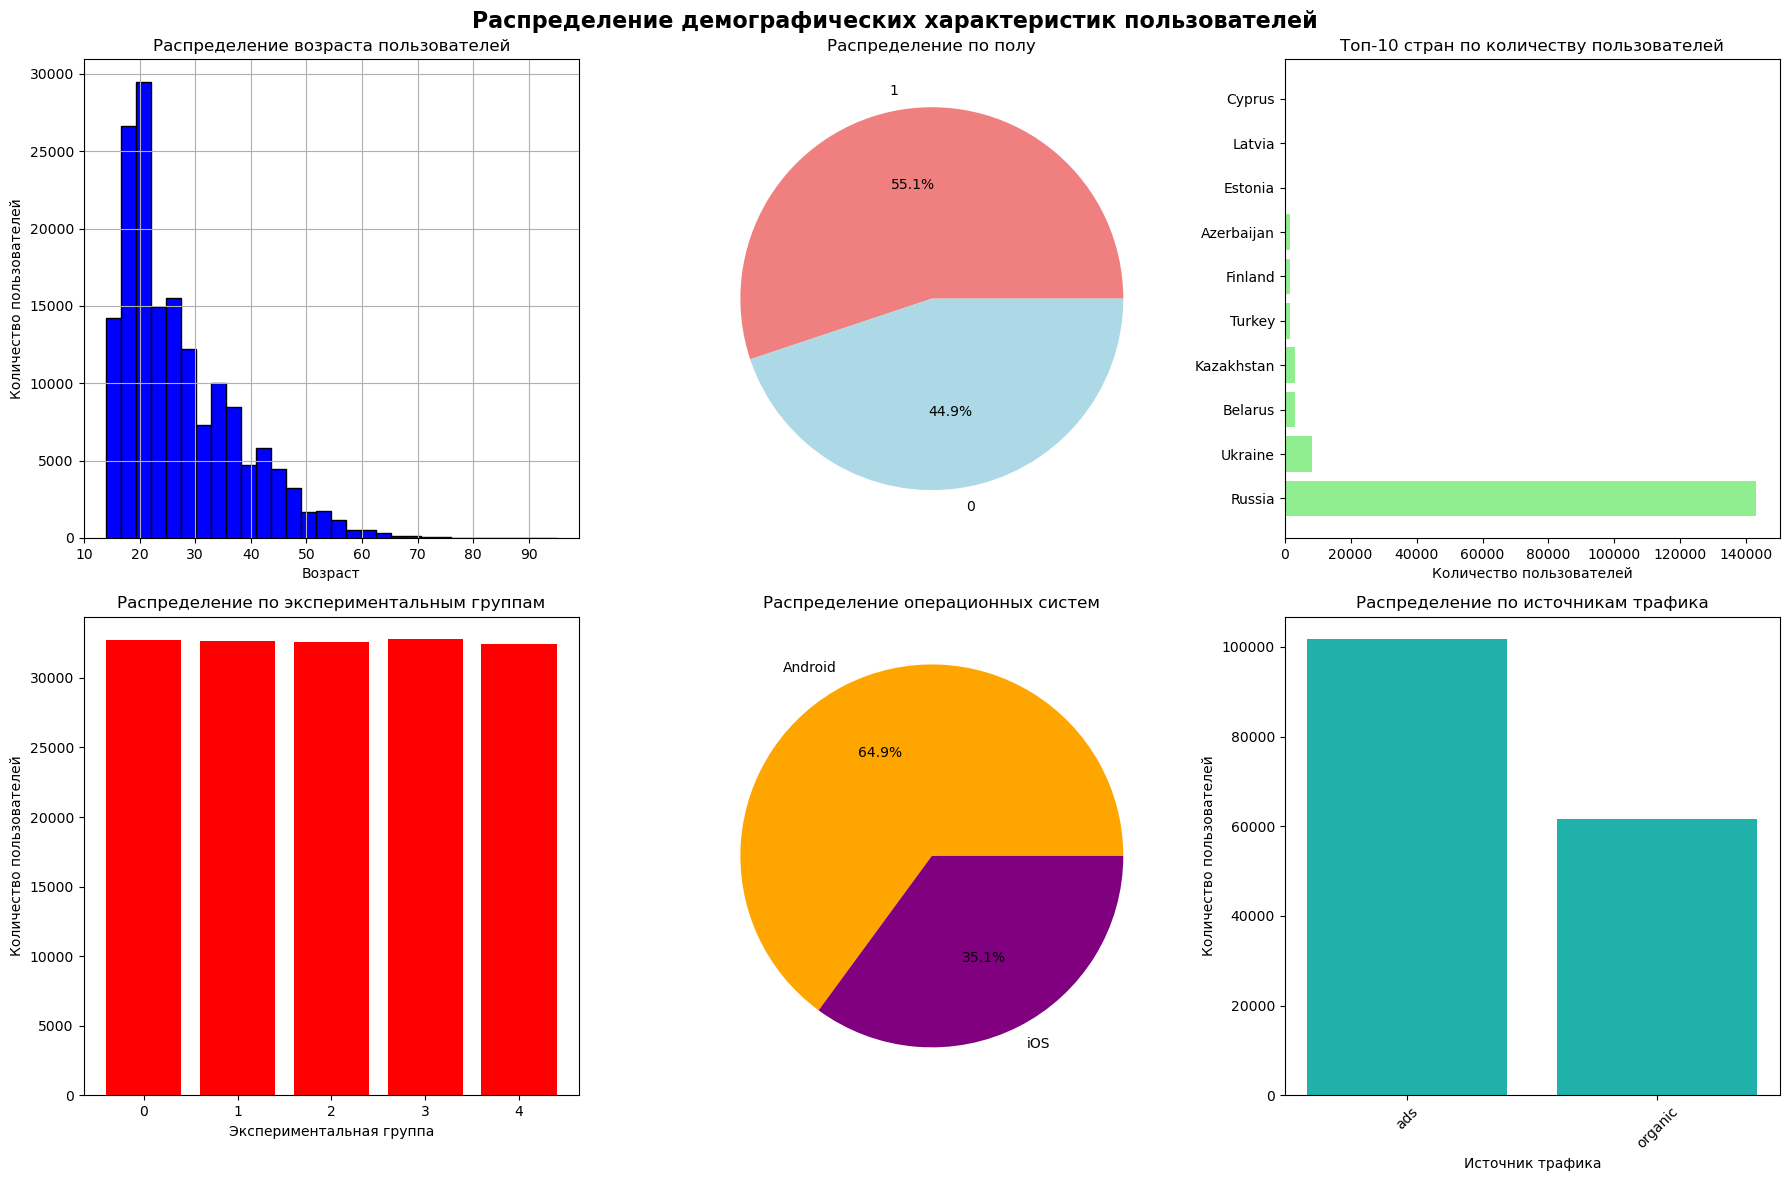

══════════════════════════════════════════════════
ДЕМОГРАФИЧЕСКАЯ СТАТИСТИКА
══════════════════════════════════════════════════

📊 Статистика по возрасту:
   Средний возраст: 27.2 лет
   Медианный возраст: 24.0 лет
   Минимальный возраст: 14 лет
   Максимальный возраст: 95 лет
   Стандартное отклонение: 10.2 лет

👥 Распределение по полу:
   1: 89,980 пользователей (55.1%)
   0: 73,225 пользователей (44.9%)

🌍 Статистика по странам:
   Всего уникальных стран: 11
   Доля топ-3 стран: 94.7%
   Топ-3 страны: Russia, Ukraine, Belarus

🔬 Экспериментальные группы:
   Группа 3: 32,768 пользователей (20.1%)
   Группа 0: 32,723 пользователей (20.1%)
   Группа 1: 32,638 пользователей (20.0%)
   Группа 2: 32,614 пользователей (20.0%)
   Группа 4: 32,462 пользователей (19.9%)

💻 Операционные системы:
   Android: 105,972 пользователей (64.9%)
   iOS: 57,233 пользователей (35.1%)

🚀 Источники трафика:
   ads: 101,685 пользователей (62.3%)
   organic: 61,520 пользователей (37.7%)

📈 Дополнительные по

In [5]:
# Анализ демографических данных пользователей

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Распределение демографических характеристик пользователей', fontsize=16, fontweight='bold')

# 1. Распределение возраста
df_users['age'].hist(bins=30, ax=axes[0,0], color='blue', edgecolor='black')
axes[0,0].set_title('Распределение возраста пользователей')
axes[0,0].set_xlabel('Возраст')
axes[0,0].set_ylabel('Количество пользователей')

# 2. Распределение по полу
gender_counts = df_users['gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
axes[0,1].set_title('Распределение по полу')

# 3. Топ-10 стран
country_top10 = df_users['country'].value_counts().head(10)
axes[0,2].barh(range(len(country_top10)), country_top10.values, color='lightgreen')
axes[0,2].set_yticks(range(len(country_top10)))
axes[0,2].set_yticklabels(country_top10.index)
axes[0,2].set_title('Топ-10 стран по количеству пользователей')
axes[0,2].set_xlabel('Количество пользователей')

# 4. Группы эксперимента
exp_counts = df_users['exp_group'].value_counts()
axes[1,0].bar(exp_counts.index, exp_counts.values, color='red')
axes[1,0].set_title('Распределение по экспериментальным группам')
axes[1,0].set_xlabel('Экспериментальная группа')
axes[1,0].set_ylabel('Количество пользователей')

# 5. Распределение операционных систем
os_counts = df_users['os'].value_counts()
axes[1,1].pie(os_counts.values, labels=os_counts.index, autopct='%1.1f%%', colors=['orange', 'purple'])
axes[1,1].set_title('Распределение операционных систем')

# 6. Источники трафика
source_counts = df_users['source'].value_counts()
axes[1,2].bar(source_counts.index, source_counts.values, color='lightseagreen')
axes[1,2].set_title('Распределение по источникам трафика')
axes[1,2].set_xlabel('Источник трафика')
axes[1,2].set_ylabel('Количество пользователей')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Демографическая статистика
print("═" * 50)
print("ДЕМОГРАФИЧЕСКАЯ СТАТИСТИКА")
print("═" * 50)

print("\n📊 Статистика по возрасту:")
print(f"   Средний возраст: {df_users['age'].mean():.1f} лет")
print(f"   Медианный возраст: {df_users['age'].median():.1f} лет")
print(f"   Минимальный возраст: {df_users['age'].min()} лет")
print(f"   Максимальный возраст: {df_users['age'].max()} лет")
print(f"   Стандартное отклонение: {df_users['age'].std():.1f} лет")

print("\n👥 Распределение по полу:")
for gender, count in gender_counts.items():
    percentage = count / len(df_users) * 100
    print(f"   {gender}: {count:,} пользователей ({percentage:.1f}%)")

print("\n🌍 Статистика по странам:")
print(f"   Всего уникальных стран: {df_users['country'].nunique()}")
print(f"   Доля топ-3 стран: {country_top10.head(3).sum() / len(df_users) * 100:.1f}%")
print(f"   Топ-3 страны: {', '.join(country_top10.head(3).index.tolist())}")

print("\n🔬 Экспериментальные группы:")
for group, count in exp_counts.items():
    percentage = count / len(df_users) * 100
    print(f"   Группа {group}: {count:,} пользователей ({percentage:.1f}%)")

print("\n💻 Операционные системы:")
for os_name, count in os_counts.items():
    percentage = count / len(df_users) * 100
    print(f"   {os_name}: {count:,} пользователей ({percentage:.1f}%)")

print("\n🚀 Источники трафика:")
for source, count in source_counts.items():
    percentage = count / len(df_users) * 100
    print(f"   {source}: {count:,} пользователей ({percentage:.1f}%)")

# Дополнительные расчеты
print("\n📈 Дополнительные показатели:")
print(f"   Пользователей старше 30 лет: {(df_users['age'] > 30).sum():,} ({(df_users['age'] > 30).sum()/len(df_users)*100:.1f}%)")
print(f"   Пользователей младше 20 лет: {(df_users['age'] < 20).sum():,} ({(df_users['age'] < 20).sum()/len(df_users)*100:.1f}%)")
print(f"   Баланс экспериментальных групп: {(exp_counts.max() - exp_counts.min()) / exp_counts.max() * 100:.1f}% разницы")

# Проверка на пропуски
print("\n🔍 Проверка пропусков:")
missing_data = df_users.isnull().sum()
missing_percent = (missing_data / len(df_users)) * 100
missing_df = pd.DataFrame({
    'Пропусков': missing_data,
    'Процент': missing_percent
})
print(missing_df[missing_df['Пропусков'] > 0])

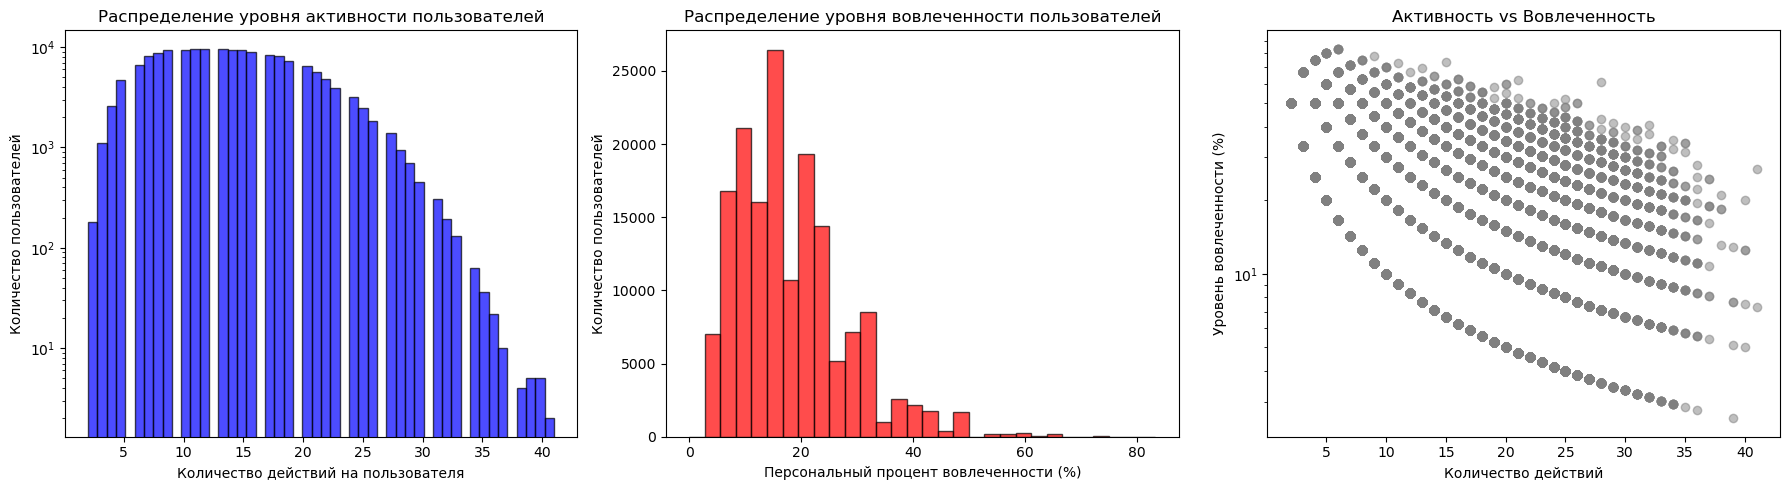

Статистика поведения пользователей:
══════════════════════════════════════════════════
Среднее количество действий на пользователя: 14.2
Медианное количество действий на пользователя: 14.0
Самый активный пользователь: 41 действий
Средний персональный уровень вовлеченности: 18.44%
Корреляция (активность ↔ вовлеченность): -0.310

Дополнительная статистика:
══════════════════════════════════════════════════
Количество пользователей: 163,205
Количество неактивных пользователей (<5 действий): 3,914
Процент неактивных пользователей: 2.4%
Пользователей с вовлеченностью >50%: 844
Процент высокововлеченных пользователей: 0.5%


In [6]:

# Анализ поведения пользователей
fig.suptitle('Анализ контента и вовлеченности пользователей', fontsize=16, fontweight='bold')

# Уровни активности пользователей
user_activity = df.groupby('user_id').size()  # количество действий на пользователя
user_engagement = df.groupby('user_id')['target'].mean()  # персональная вовлеченность

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Распределение активности пользователей
axes[0].hist(user_activity, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Распределение уровня активности пользователей')
axes[0].set_xlabel('Количество действий на пользователя')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_yscale('log')

# 2. Распределение вовлеченности пользователей
axes[1].hist(user_engagement * 100, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Распределение уровня вовлеченности пользователей')
axes[1].set_xlabel('Персональный процент вовлеченности (%)')
axes[1].set_ylabel('Количество пользователей')

# 3. Связь между активностью и вовлеченностью
axes[2].scatter(user_activity, user_engagement * 100, alpha=0.5, color='grey')
axes[2].set_title('Активность vs Вовлеченность')
axes[2].set_xlabel('Количество действий')
axes[2].set_ylabel('Уровень вовлеченности (%)')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

# Статистика
print("Статистика поведения пользователей:")
print("═" * 50)
print(f"Среднее количество действий на пользователя: {user_activity.mean():.1f}")
print(f"Медианное количество действий на пользователя: {user_activity.median():.1f}")
print(f"Самый активный пользователь: {user_activity.max()} действий")
print(f"Средний персональный уровень вовлеченности: {user_engagement.mean() * 100:.2f}%")
print(f"Корреляция (активность ↔ вовлеченность): {user_activity.corr(user_engagement):.3f}")

# Дополнительная статистика
print("\nДополнительная статистика:")
print("═" * 50)
print(f"Количество пользователей: {len(user_activity):,}")
print(f"Количество неактивных пользователей (<5 действий): {(user_activity < 5).sum():,}")
print(f"Процент неактивных пользователей: {(user_activity < 5).sum()/len(user_activity)*100:.1f}%")
print(f"Пользователей с вовлеченностью >50%: {(user_engagement > 0.5).sum():,}")
print(f"Процент высокововлеченных пользователей: {(user_engagement > 0.5).sum()/len(user_engagement)*100:.1f}%")

In [7]:
user_likes = df.groupby('user_id')['target'].sum().reset_index(name='total_likes')

In [8]:
user_activity = df.groupby('user_id').size() 
user_activity.describe()

count    163205.000000
mean         14.196330
std           5.988539
min           2.000000
25%           9.000000
50%          14.000000
75%          18.000000
max          41.000000
dtype: float64

In [9]:
# Преобразуем Series в DataFrame и сбрасываем индекс
user_activity_df = user_activity.reset_index(name='activity_count')

# Определяем границы интервалов
bins = [0, 9, 10, 11, 12, 13, 15, float('inf')]
labels = ['≤8', '9', '10', '11', '12', '13', '≥14']

user_activity_df['activity_group'] = pd.cut(
    user_activity_df['activity_count'], 
    bins=bins, 
    labels=labels, 
    right=False
)

activity_counts = user_activity_df['activity_group'].value_counts().sort_index()

print("Распределение пользователей по активности:")
print("-" * 50)
for group, count in activity_counts.items():
    percentage = count / len(user_activity_df) * 100
    print(f"{group:3} действий: {count:7,} пользователей ({percentage:5.1f}%)")

print(f"\nВсего пользователей: {len(user_activity_df):,}")

Распределение пользователей по активности:
--------------------------------------------------
≤8  действий:  32,046 пользователей ( 19.6%)
9   действий:   9,281 пользователей (  5.7%)
10  действий:   9,298 пользователей (  5.7%)
11  действий:   9,483 пользователей (  5.8%)
12  действий:   9,545 пользователей (  5.8%)
13  действий:  19,029 пользователей ( 11.7%)
≥14 действий:  74,523 пользователей ( 45.7%)

Всего пользователей: 163,205


# Создание признаков

In [10]:
topic = df_pt.drop(['text'], axis=1)
df = pd.merge(df, topic, on='post_id',how='left')

# Преобразуем topic в числовые коды
df['topic_code'] = df['topic'].astype('category').cat.codes

# Сохраняем mapping для интерпретации
topic_mapping = dict(enumerate(df['topic'].astype('category').cat.categories))

print("Topic mapping:")
for code, topic_name in topic_mapping.items():
    print(f"  {code}: {topic_name}")

Topic mapping:
  0: business
  1: covid
  2: entertainment
  3: movie
  4: politics
  5: sport
  6: tech


In [11]:
df.sample(1)

,user_id,gender,age,country,city,exp_group,os,source,post_id,action,timestamp,target,topic,topic_code
1737044,127720,0,33,Russia,Moscow,1,iOS,organic,7136,view,2021-11-28 07:10:24,0,movie,3


In [12]:
### суммируем все таргеты по  категориям у уникального юзера 
df_model_agg = df[['user_id','topic']]

topic_dummies = pd.get_dummies(df_model_agg['topic'], prefix='topic').astype(int)
df_model_agg = pd.concat([df_model_agg, topic_dummies], axis=1)

df_model_agg = df_model_agg.drop(['topic'], axis=1)

sum_cols = df_model_agg.groupby('user_id')[['topic_business','topic_covid','topic_entertainment','topic_movie','topic_politics','topic_sport','topic_tech']].sum()
first_cols = df_model_agg.groupby('user_id').first().drop(['topic_business','topic_covid','topic_entertainment','topic_movie','topic_politics','topic_sport','topic_tech'], axis=1)
df_model_agg = pd.concat([first_cols, sum_cols], axis=1).reset_index()
###  создаем профиль юзера
topic_cols = list(dict.fromkeys(['topic_business','topic_covid','topic_entertainment','topic_movie','topic_politics','topic_sport','topic_tech']))
user_profile = df_model_agg[['user_id'] + topic_cols].copy()
user_profile[topic_cols] = user_profile[topic_cols].div(user_profile[topic_cols].sum(axis=1), axis=0)
# Мержим только по общим user_id
df_model = pd.merge(
    df,
    user_profile,
    on='user_id', 
    how='inner'
)


In [13]:
df_model.sample(1)

,user_id,gender,age,country,city,exp_group,os,source,post_id,action,...,target,topic,topic_code,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
1506966,111542,0,18,Russia,Domodedovo,0,Android,organic,6222,view,...,0,movie,3,0.0,0.0,0.111111,0.444444,0.444444,0.0,0.0


In [14]:
# Создание возрастных категорий
age_bins = [0, 18, 21, 25, 32, 41, 52, 150]
age_labels = ['0-17', '18-20', '21-24', '25-31', '32-40','41-51', '52-150']
df_model['age_category'] = pd.cut(df_model['age'], bins=age_bins, labels=age_labels)
age_mapping = {category: code for code, category in enumerate(df_model['age_category'].unique())}
df_model['age_category'] = df_model['age_category'].map(age_mapping).astype('category')
# Проверка
print(df_model['age_category'].value_counts())
df_model.head(2)

age_category
1    438904
3    429495
4    424180
2    413588
0    359142
5    196104
6     55499
Name: count, dtype: int64


,user_id,gender,age,country,city,exp_group,os,source,post_id,action,...,topic,topic_code,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,age_category
0,200,1,34,Russia,Degtyarsk,3,Android,ads,1814,view,...,sport,5,0.1,0.2,0.1,0.2,0.1,0.3,0.0,0
1,200,1,34,Russia,Degtyarsk,3,Android,ads,668,view,...,entertainment,2,0.1,0.2,0.1,0.2,0.1,0.3,0.0,0


In [15]:
# День недели (циклический)
df_model['dow_sin'] = np.sin(2 * np.pi * df_model['timestamp'].dt.dayofweek / 7)
df_model['dow_cos'] = np.cos(2 * np.pi * df_model['timestamp'].dt.dayofweek / 7)

# Время дня (час) (циклический)
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['timestamp'].dt.hour / 24)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['timestamp'].dt.hour / 24)

In [16]:
cols_to_drop = [
    'country', 'city',     # Есть one-hot encoded версии
    'os', 'source',        # Есть encoded версии
    'topic',               # Есть one-hot
    'age',                 # Ужеиспользую age_category 
    'action',
    'topic_covid',
    #'topic_business','topic_entertainment', 'topic_tech', 

]
df_model_clean = df_model.drop(columns=cols_to_drop)

In [17]:
df_model_clean.sample(2)

,user_id,gender,exp_group,post_id,timestamp,target,topic_code,topic_business,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,age_category,dow_sin,dow_cos,hour_sin,hour_cos
221199,15814,0,4,7024,2021-10-31 15:38:53,1,3,0.050000,0.1,0.350000,0.200000,0.150,0.000000,2,-0.781831,0.623490,-0.707107,-0.707107
532553,37777,1,1,2911,2021-10-28 17:21:37,0,1,0.041667,0.0,0.416667,0.041667,0.125,0.041667,3,0.433884,-0.900969,-0.965926,-0.258819


In [18]:
# Задаем новый порядок колонок
new_order = [
    'timestamp',
    'user_id', 
    'post_id',
    'target',
    'age_category',
    'gender',
    'exp_group',
    'hour_sin',
    'hour_cos',
    'dow_sin', 
    'dow_cos',
    'topic_code',
    'topic_movie', 'topic_politics', 'topic_sport', 'topic_business','topic_entertainment', 'topic_tech',
]

# Переставляем колонки
df_model_clean = df_model_clean[new_order]
df_model_clean.sample(1)

,timestamp,user_id,post_id,target,age_category,gender,exp_group,hour_sin,hour_cos,dow_sin,dow_cos,topic_code,topic_movie,topic_politics,topic_sport,topic_business,topic_entertainment,topic_tech
2045664,2021-10-07 18:10:39,149518,3325,0,4,1,2,-1.0,-1.836970e-16,0.433884,-0.900969,1,0.35,0.1,0.05,0.1,0.1,0.1


In [19]:
### СОЗДАНИЕ ЭМБЭДИНГОВ ПОСТОВ ДЛЯ  ТАБЛИЦЫ ФИЧ
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


# 1. Берем ВСЕ посты
all_posts = df_pt[['post_id', 'text']].copy()

# 2. Создаем TF-IDF эмбеддинги
vectorizer = TfidfVectorizer(
    max_features=2,  # ТОЛЬКО 2
    ngram_range=(1, 2),  # +биграммы
    min_df=3,  # убрать редкие
    max_df=0.7  # убрать слишком частые
)

# 3. Обучаем на ВСЕХ текстах постов
tfidf_matrix = vectorizer.fit_transform(all_posts['text'].astype(str))

# 4. Создаем DataFrame с эмбеддингами
post_embeddings_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f'post_embed_{i}' for i in range(2)]
)
post_embeddings_df['post_id'] = all_posts['post_id'].values

# 5. Сохраняем
post_embeddings_df.to_csv('post_embeddings_10.csv', index=False)

# 6. Проверка
print("═" * 50)
print("POST ЭМБЕДДИНГИ СОЗДАНЫ")
print("═" * 50)
print(f"Постов обработано: {len(post_embeddings_df)}")
print(f"Размерность: {2} фичи")
print("\nКолонки:")
print(post_embeddings_df.columns.tolist())

══════════════════════════════════════════════════
POST ЭМБЕДДИНГИ СОЗДАНЫ
══════════════════════════════════════════════════
Постов обработано: 7023
Размерность: 2 фичи

Колонки:
['post_embed_0', 'post_embed_1', 'post_id']


In [20]:
df_model_clean = pd.merge(
    df_model_clean,
    post_embeddings_df,
    on='post_id', 
    how='inner'
)

In [21]:
df_model_clean.shape

(2316912, 20)

In [22]:
df_model_clean.sample(2)

,timestamp,user_id,post_id,target,age_category,gender,exp_group,hour_sin,hour_cos,dow_sin,dow_cos,topic_code,topic_movie,topic_politics,topic_sport,topic_business,topic_entertainment,topic_tech,post_embed_0,post_embed_1
455114,2021-10-22 13:36:25,32336,150,0,4,1,2,-0.258819,-0.965926,-0.433884,-0.900969,0,0.538462,0.038462,0.038462,0.153846,0.115385,0.0000,0.697619,0.716469
2153710,2021-10-29 10:44:38,157119,5180,0,4,1,0,0.500000,-0.866025,-0.433884,-0.900969,3,0.375000,0.000000,0.000000,0.125000,0.000000,0.0625,0.437727,0.899108


In [23]:
df_model_clean.to_csv('df_final_clean.csv', index=False)